# Introduction

In this workbook, we demonstrate the usage of Graphs.jl to execute diffusion simulations on random graphs. The broad aim is to replicate the results from the influential paper, "A simple model of global cascades on random networks".

Watts, D. J. (2002). A simple model of global cascades on random networks. Proceedings of the National Academy of Sciences, 99(9), 5766-5771.

## Outline

Through this model, Watts demonstrated that a simple threshold rule could be used as a basis to explain global cascades, i.e., events where small initial random shocks spread to a significant proportion of the network. 

One rather surprising result from this study is that even when the average degree of the network is low, a global cascade can be triggered by randomly chosen seeds. This throws a spaner in the usual conception that large scale diffusions on a network are triggered only by "special people", i.e., influencers. 

## Model

A node in a graph is faced with a binary decision - to engage or to not engage (e.g., with new products or discussions with friends). They make this decision based on a simple rule - they compute the fraction of their neighbors that have engaged, compare it with their personal threshold, and engage if the fraction of engaged neighbors exceeds the threshold. In other words, the thought process is on the lines, "If at least 18% of my friends bought the new iPhone, I would want to buy it too".

The execution of this model is random and asynchronous, i.e., each node checks the status of its neighbors in a random order and decides whether to engage or not depending on the fraction of neighbors engaged at that point

In [1]:
using Pkg
for pkg in ["Graphs", "Plots", "GR"]
    Pkg.add(pkg)
end

    Updating registry at `C:\Users\Thibaut\.julia\registries\General`
    Updating git-repo `https://github.com/JuliaRegistries/General.git`
   Resolving package versions...
  No Changes to `C:\Users\Thibaut\.julia\environments\v1.8\Project.toml`
  No Changes to `C:\Users\Thibaut\.julia\environments\v1.8\Manifest.toml`
   Resolving package versions...
  No Changes to `C:\Users\Thibaut\.julia\environments\v1.8\Project.toml`
  No Changes to `C:\Users\Thibaut\.julia\environments\v1.8\Manifest.toml`
   Resolving package versions...
  No Changes to `C:\Users\Thibaut\.julia\environments\v1.8\Project.toml`
  No Changes to `C:\Users\Thibaut\.julia\environments\v1.8\Manifest.toml`


In [2]:
using Distributions
using Graphs
using Plots; gr()
using Random: shuffle, seed!

# make sure this tutorial is reproducible
seed!(20130810);

In [4]:
function fraction_engaged(node::Int,
                          G::Graphs.SimpleGraphs.SimpleGraph,
                          node_status::BitVector)
    """
    Computes the fraction of neighbors engaged within the neighborhood
    of a given node. It uses the node status to check the engagement status of
    each of the nodes neighbors
    """
    num_engaged_neighbors = 0
    for nbr in neighbors(G, node)
        if node_status[nbr] == true
            num_engaged_neighbors += 1
        end
    end
    return num_engaged_neighbors/length(neighbors(G, node))
end

fraction_engaged (generic function with 1 method)

In [5]:
function update_node_status!(G::Graphs.SimpleGraphs.SimpleGraph,
                             node_status::BitVector,
                             threshold::Vector{Float64})
    """
    This function executes the random asynchronous updates of the entire network
    at each time step. In this conceptualization, each time step comprises mini
    time steps where a randomly shuffled node list updates at each iteration
    """
    
    for node in shuffle(vertices(G))
        if node_status[node] == false
            if fraction_engaged(node, G, node_status) > threshold[node]
                node_status[node] = true
            end
        end
    end

    return nothing
end

update_node_status! (generic function with 1 method)

In [6]:
function diffusion_simulation(n::Int,
                              z::Int,
                              threshold::Vector{Float64},
                              T::Int,
                              n_realizations::Int)
    """
    Executes the diffusion simulation.
    It creates a new Watts-Strogatz graph at each realization and seeds a single node
    (initialization). It then updates the network for the defined tnumber of time
    steps.

    The idea is to run the diffusion simulation a very large number
    of times and count the instances where we observe a
    global cascade, i.e., number of nodes engaged after the simulation
    process is a sizeable proportion of the network

    Hyper Parameters of the model
    ----------
    1. Number of nodes in the Watts-Strogatz graph (n)
    2. Average degree (z)
    3. Threshold (distribution or a specific value)
    4. Time steps for simulation to be run
    5. Number of realizations

    Output
    -----------
    A vector of number of engaged nodes at the end of each realization
    of the simulation

    Intended usage of results
    -----------
    Plot the cascades on the z-ϕ phase space; replicate results from
    "A simple model of global cascades on random networks", Watts (2002)
    """

    output = Vector{Int}(undef, n_realizations)
    beta = z/n

    for r in 1:n_realizations
        G = watts_strogatz(n, z, beta)
        # Select a single random node from the network and seed it
        node_status = falses(nv(G))
        node_status[sample(vertices(G))] = true

        # Update the network for predefined number of time steps
        for _ in 1:T
            update_node_status!(G, node_status, threshold)
        end
        output[r] = sum(node_status)
    end

    return output

end

diffusion_simulation (generic function with 1 method)

## Results

We have two parameters that we wish to explore - the average degree of the network and the threshold for engagement. While we leave the full exploration of the parameter space to the reader, we demonstrate how this exploration could be done below. We take the example of two particular values of (z, $\phi$), i.e., (5, 0.18) and (6, 0.18) at which a phase transition occurs, i.e., at average network degree of 5 global cascades occur while at degree 6 no cascades occur irrespective of threshold!

In [7]:
const N = 10^4
z, threshold = 5, 0.18

@time data = diffusion_simulation(N, z, fill(threshold, N), 50, 100);

  2.289443 seconds (2.01 M allocations: 526.882 MiB, 3.20% gc time, 0.33% compilation time)


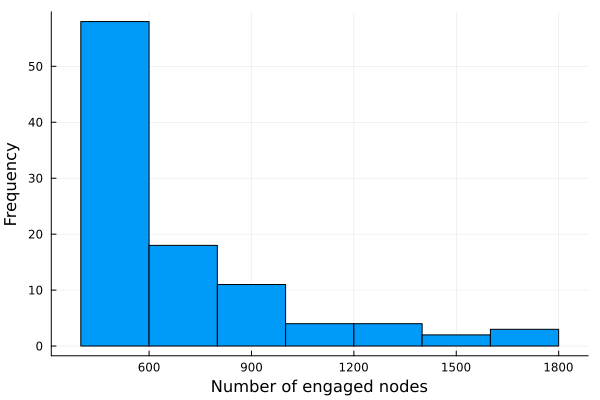

In [8]:
histogram(data, xlab="Number of engaged nodes", ylab="Frequency", legend=false)

In [9]:
z, threshold = 6, 0.18

@time data = diffusion_simulation(N, z, fill(threshold, N), 50, 100);

  3.093600 seconds (2.01 M allocations: 526.875 MiB, 2.25% gc time)


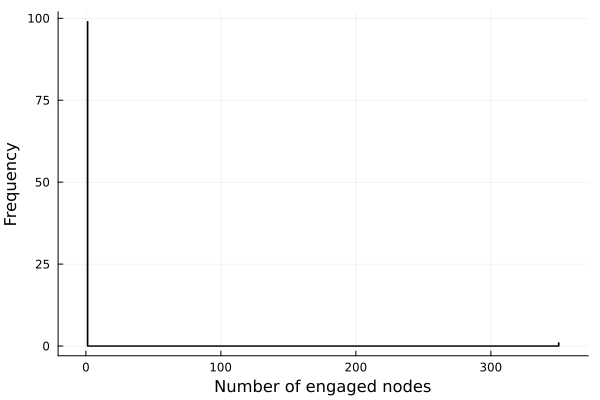

In [10]:
histogram(data, xlab="Number of engaged nodes", ylab="Frequency", legend=false)

As can be seen from these two graphs, no global cascade occurs in the second case, while there are a few in the first! It is remarkable that just increasing the average degree of the network by 1 changes the entire outcome of the diffusion process. The code presented in this notebook can be used to reproduce all the results discussed in Watts (2002) by executing the simulations at $z \in (1, 16)$ and $\phi \in (0.1, 0.26)$ 